# Some quick analysis of ride + weather data

In what follows, let us take a brief look at the data and see what we can find

First we load the typical libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## The basic datasets available to us

In [2]:
ride_data = pd.read_csv('relay_ride_data_cleaned.csv')
weather_data = pd.read_csv('atlanta_weather_data_clean.csv')
crime_data = pd.read_csv('atlanta_crime_occurance_data_cleaned.csv')

What columns occur in this dataset? 

In [3]:
ride_data.columns

Index(['user_id', 'start_hub', 'start_latitude', 'start_longitude', 'end_hub',
       'end_latitude', 'end_longitude', 'total_distance', 'total_cost',
       'start_time_iso', 'end_time_iso'],
      dtype='object')

In [4]:
ride_data.head()

,user_id,start_hub,start_latitude,start_longitude,end_hub,end_latitude,end_longitude,total_distance,total_cost,start_time_iso,end_time_iso
0,503796,ATLANTIC STATION,33.79151167,-84.39623167,ATLANTIC STATION,33.79153167,-84.39630333,0.08,0.75,2017-09-14 00:08:00,2017-09-14 00:13:00
1,503796,ATLANTIC STATION,33.791545,-84.39639667,ATLANTIC STATION,33.79151667,-84.39632667,0.05,0.45,2017-09-14 00:13:00,2017-09-14 00:16:00
2,528737,AUC - WOODRUFF LIBRARY,33.75217333,-84.41330833,AUC - WOODRUFF LIBRARY,33.75205,-84.413325,1.53,0.00,2017-09-14 00:18:00,2017-09-14 00:44:00
3,529805,AUC - WOODRUFF LIBRARY,33.75196167,-84.413245,AUC - WOODRUFF LIBRARY,33.752025,-84.41331,1.08,0.00,2017-09-14 00:18:00,2017-09-14 00:42:00
4,528758,AUC - WOODRUFF LIBRARY,33.751875,-84.41334,AUC - WOODRUFF LIBRARY,33.75204167,-84.413315,1.70,0.00,2017-09-14 00:18:00,2017-09-14 00:45:00


Let us add some datetime columns to the dataframe so this is easier to analyze

In [5]:
ride_data['start_time_dt'] = pd.to_datetime(ride_data.start_time_iso)
ride_data['end_time_dt'] = pd.to_datetime(ride_data.end_time_iso)


### How many rides occur on each weekday?

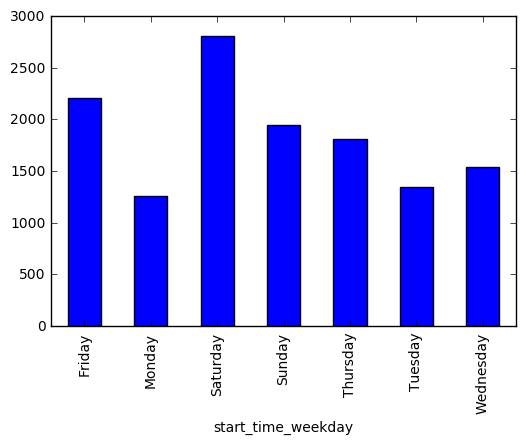

In [6]:
ride_data['start_time_weekday'] = ride_data.start_time_dt.dt.weekday_name
rides_per_weekday = ride_data.groupby('start_time_weekday')['user_id'].count()
rides_per_weekday.plot(kind='bar')

## Let us look at the weather data

We will see what is in the weather data, and organize information about the weather by date/hour

In [7]:
weather_data.columns

Index(['timestamp', 'timestamp_iso', 'temperature', 'temp_min_predicted',
       'temp_max_predicted', 'pressure', 'humidity', 'wind_speed',
       'rain_1h_predicted', 'cloud_cover', 'weather_description'],
      dtype='object')

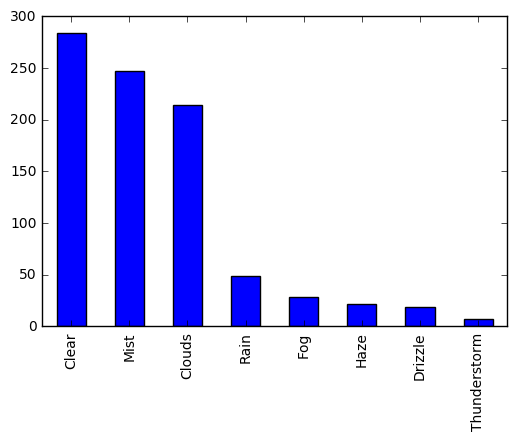

In [8]:
weather_data['datetime'] = pd.to_datetime(weather_data.timestamp,origin='unix',unit='s')
weather_data['monthdayhour'] = weather_data.datetime.dt.strftime('%m/%d:%H')
weather_data.weather_description.value_counts().plot(kind='bar')

## Let's connect the day/hour to the weather

I'm going to create a map to use later. This will connect the current day and hour to the weather conditions. In my weather data, sometimes I have multiple entries for a day/hour and I will group these and select the most likely.

In [9]:
weather_desc_groups = weather_data.groupby('monthdayhour')['weather_description']
weather_by_hour = weather_desc_groups.agg(lambda x:x.value_counts().index[0])


## Grouping rides by the weekday/hour

I want to see how many rides are occuring in each weekday and hour, so I can use these as features to train a regressor and see how much they contribute to the overall rider use.

Let's also plot a histogram of how many rides occur per day.

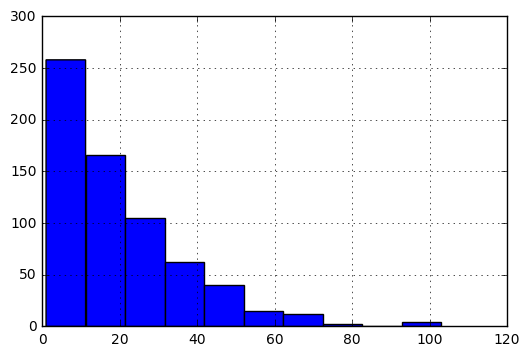

In [10]:
# Get the datetime but drop the minutes and seconds
ride_data['start_time_dt_hoursonly'] = pd.to_datetime(ride_data.start_time_iso).apply(
    lambda date: date.replace(minute=0, second=0))

# Now create the groups
num_rides_per_hour = ride_data.groupby('start_time_dt_hoursonly')['user_id'].count().rename('num_rides')
num_rides_per_hour.hist()

## Making a dataset

Now we have a count of how many rides occured in each day/hour. I want to see if we can learn this from features. Let's create a little dataset for this.

In [11]:
# This 
num_rides_per_hour = num_rides_per_hour.reset_index()
num_rides_per_hour['log_num_rides'] = num_rides_per_hour.num_rides.map(lambda x: np.log(x + 1.))
num_rides_per_hour['weekday'] = num_rides_per_hour.start_time_dt_hoursonly.dt.weekday_name
num_rides_per_hour['hour'] = num_rides_per_hour.start_time_dt_hoursonly.dt.strftime("%H:00")

# Previously we constructed the day/hour weather map. We can now fill in weather conditions:
num_rides_per_hour['monthdayhour'] = num_rides_per_hour.start_time_dt_hoursonly.dt.strftime('%m/%d:%H')
num_rides_per_hour['weather_condition'] = num_rides_per_hour.monthdayhour.map(weather_by_hour)

# Let's take a look at our new dataset
num_rides_per_hour.head()

,start_time_dt_hoursonly,num_rides,log_num_rides,weekday,hour,monthdayhour,weather_condition
0,2017-09-14 00:00:00,11,2.484907,Thursday,00:00,09/14:00,Clouds
1,2017-09-14 01:00:00,2,1.098612,Thursday,01:00,09/14:01,Clouds
2,2017-09-14 02:00:00,3,1.386294,Thursday,02:00,09/14:02,Clouds
3,2017-09-14 06:00:00,5,1.791759,Thursday,06:00,09/14:06,Mist
4,2017-09-14 07:00:00,19,2.995732,Thursday,07:00,09/14:07,Mist


In [12]:
X = pd.get_dummies(num_rides_per_hour[['weekday','weather_condition','hour']])
Y = num_rides_per_hour['log_num_rides']

## Fitting the model, and extracting coefficients

We now have an X and a Y. We want to see if we can estimate Y from X. Let's try a simple linear model.

In [13]:
regr = linear_model.LinearRegression(normalize=True,fit_intercept=False)
regr.fit(X,Y)

/Users/jacob/anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

### Grouping the models coefficients

We used three types of coefficients: day, hour, weathercondition. Let's look at each of these separately.

In [14]:
coefficients = pd.Series(regr.coef_,index=X.columns)
weather_coeffs = coefficients.loc[[ind for ind in coefficients.index if "weather_" in ind]]
hour_coeffs = coefficients.loc[[ind for ind in coefficients.index if "hour_" in ind]]
weekday_coeffs = coefficients.loc[[ind for ind in coefficients.index if "weekday_" in ind]]


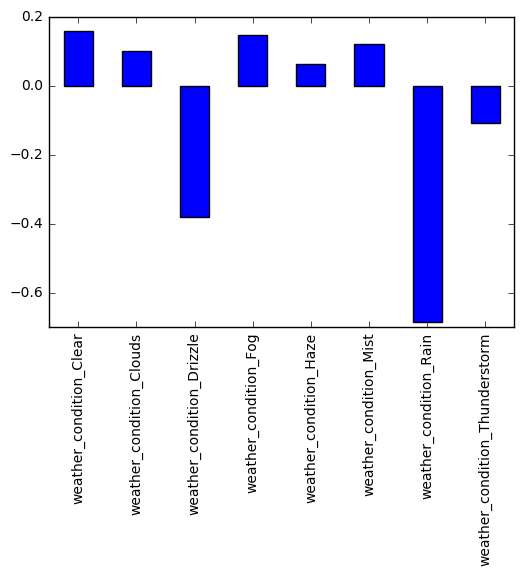

In [15]:
weather_coeffs.plot(kind='bar')

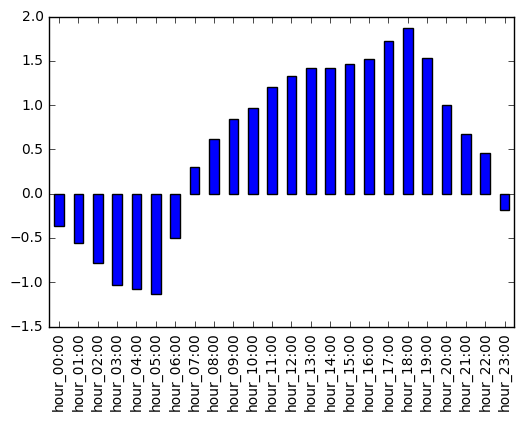

In [16]:
hour_coeffs.plot(kind='bar')

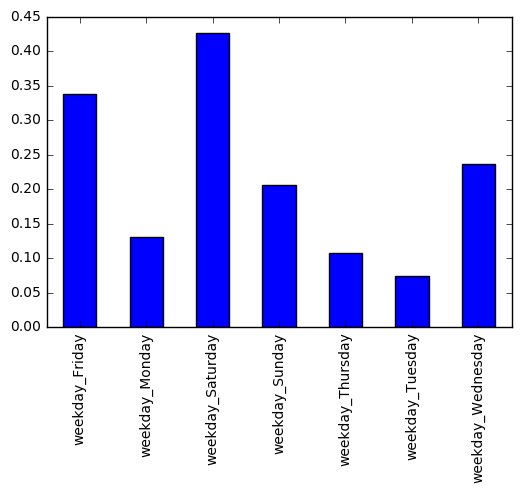

In [17]:
weekday_coeffs = (weekday_coeffs - 1.6)
weekday_coeffs.plot(kind='bar')